# 1. **Importing libraries and loading data**

## **1.1 Importing libraries**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

from rapidfuzz import process, fuzz
from dython.nominal import associations

import os 

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

## **1.2 Importing the datasets**

In [2]:
# extract the project data zip file
z = zipfile.ZipFile('project_data.zip')
z.extractall()

del z

In [3]:
# Load the data (train and test)
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

# 2. **Removing duplicates, Data inconsistencies and Splitting the data**

## Removing Duplicates, Setting the index and removing empty target values and empty feature

In [4]:
# Check for missing values in target variable 'Claim Injury Type'
df_train['Claim Injury Type'].isnull().sum()

19445

In [5]:
# Drop the columns that have Claim inury type missing
df_train = df_train.dropna(subset=['Claim Injury Type'])

In [6]:
# Drop the feature 'OIICS Nature of Injury Description' because it has no values
df_train = df_train.drop(columns=['OIICS Nature of Injury Description'])
df_test = df_test.drop(columns=['OIICS Nature of Injury Description'])

In [7]:
# Make'claim identifier' as index
df_train = df_train.set_index('Claim Identifier')
df_test = df_test.set_index('Claim Identifier')

In [8]:
# Check for duplicates in indexes
print(df_train.index.duplicated().sum())

0


In [9]:
# Check duplicates
print(df_train.duplicated().sum())

1


In [10]:
# Drop that 1 duplicate
df_train = df_train.drop_duplicates()

## Checking for data inconsistencies

We're going to check if there is data that was incorrectly inputted.
Let's start with dates: If there's any type of date before the accident date, we're going to remove it.

### Dates

In [11]:
# Identify rows with inconsistencies
invalid_rows = df_train[
    (df_train['C-2 Date'] < df_train['Accident Date']) | 
    (df_train['Assembly Date'] < df_train['Accident Date']) |
    (df_train['C-3 Date'] < df_train['Accident Date']) |
    (df_train['First Hearing Date'] < df_train['Accident Date'])
]

# Display the invalid rows for review
print(invalid_rows.shape)

(1701, 31)


There are 1701 rows with dates before the accident date. We're going to remove them.

In [12]:
# Drop invalid_rows   
df_train = df_train.drop(invalid_rows.index)

### Zip Codes

There are zip codes with letters in them and with less or more than 5 digits. We're going to analyse them.

In [13]:
def count_digit(string):
    """Count the number of digits in a string."""
    
    # Use a generator expression to check each character in the string
    #c.isdigit() returns True for digits, and sum adds up all True values
    return sum(c.isdigit() for c in str(string))

# Identify outliers in the Zip Code column (does not have exactly 5 digits or
# contains an alphabetic character
zip_outliers = df_train[df_train['Zip Code'].apply(
    lambda x: (count_digit(str(x)) != 5) or any(char.isalpha() for char in str(x))
)]
# Output the shape of the resulting DataFrame
zip_outliers.shape

(43373, 31)

In [14]:
# Display the count of each Claim Injury Type in the outlier rows
df_train.loc[zip_outliers.index, 'Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        21832
4. TEMPORARY       11091
3. MED ONLY         5385
5. PPD SCH LOSS     3746
1. CANCELLED         945
6. PPD NSL           338
8. DEATH              31
7. PTD                 5
Name: count, dtype: int64

We'll tranform the zip codes with incoherences to NaN because there are incosistencies in data imputation. We'll later fill with the mode based on the context of each row.

In [15]:
# Transform zip outliers indexes into NaN
df_train.loc[zip_outliers.index, 'Zip Code'] = np.nan

### Carrier Name

In [16]:
#!pip install rapidfuzz

In [17]:
print(df_train['Carrier Name'].value_counts())

Carrier Name
STATE INSURANCE FUND            110816
POLICE, FIRE, SANITATION         21542
AMERICAN ZURICH INSURANCE CO     17496
CHARTER OAK FIRE INS CO          17122
INDEMNITY INS. OF N AMERICA      14341
                                 ...  
LOWES HOME CENTERS INC               1
WEST BEND MUTUAL INSURANCE           1
LIVINGSTON-STEUBEN-                  1
NEW YORK MUTUAL CASUALTY             1
HERMON-DEKALB CENTRAL                1
Name: count, Length: 2046, dtype: int64


In [18]:
# Get unique carrier names
unique_names = df_train['Carrier Name'].dropna().unique()

# Create a mapping of similar names to canonical names
canonical_mapping = {}

for name in unique_names:
    # Handle the case where canonical_mapping.keys() is empty
    if not canonical_mapping:
        canonical_mapping[name] = name  # Treat the first name as canonical
        continue
    
    # Find the closest match in the current canonical_mapping
    result = process.extractOne(name, canonical_mapping.keys(), scorer=fuzz.ratio)
    
    if result:  # Ensure a match was found
        match, score = result[:2]  # Unpack match and score
        if score > 85:  # Threshold for similarity
            canonical_mapping[name] = canonical_mapping[match]
        else:
            canonical_mapping[name] = name  # Treat as canonical
    else:
        canonical_mapping[name] = name  # No match found, treat as canonical

# Apply the mapping
df_train['Carrier Name'] = df_train['Carrier Name'].map(canonical_mapping)

In [19]:
print(df_train['Carrier Name'].value_counts())

Carrier Name
STATE INSURANCE FUND              110816
POLICE, FIRE, SANITATION           21542
AMERICAN ZURICH INSURANCE CO       17496
CHARTER OAK FIRE INS CO            17122
INDEMNITY INS. OF N AMERICA        14341
                                   ...  
HERMON-DEKALB CSD                      1
NEW YORK MUTUAL CASUALTY               1
WINDHAM-ASHLAND-JEWETT                 1
EASTERN ALLIANCE INSUR COMPANY         1
HERMON-DEKALB CENTRAL                  1
Name: count, Length: 1504, dtype: int64


### Age at Injury and Birth Year

In [20]:
# Value counts for 'Age at Injury'
print(df_train['Age at Injury'].value_counts().sort_index())

Age at Injury
0.0      5463
1.0         2
5.0         1
7.0         2
8.0         6
         ... 
112.0      24
113.0       1
114.0       1
115.0       1
117.0       2
Name: count, Length: 108, dtype: int64


In [21]:
# Filter the dataframe for rows where 'Age at Injury' is 0.0
age_zero_df = df_train[df_train['Age at Injury'] == 0.0]

# Display the target values for these rows
# Calculate the percentage of each target value in age_zero_df compared to the whole 'Claim Injury Type' in df_train
percentage = (age_zero_df['Claim Injury Type'].value_counts() / df_train['Claim Injury Type'].value_counts()) * 100
print(percentage)

Claim Injury Type
1. CANCELLED       13.874177
2. NON-COMP         0.993515
3. MED ONLY         0.366381
4. TEMPORARY        0.383356
5. PPD SCH LOSS     0.044263
6. PPD NSL          0.023838
7. PTD                   NaN
8. DEATH            0.426439
Name: count, dtype: float64


In [22]:
# Filter the dataframe for rows where 'Age at Injury' is 0.0
age_zero_df = df_train[df_train['Birth Year'] == 0.0]

# Display the target values for these rows
# Calculate the percentage of each target value in age_zero_df compared to the whole 'Claim Injury Type' in df_train
percentage = (age_zero_df['Claim Injury Type'].value_counts() / df_train['Claim Injury Type'].value_counts()) * 100
print(percentage)

Claim Injury Type
2. NON-COMP         4.725641
4. TEMPORARY        3.893632
3. MED ONLY         3.290127
5. PPD SCH LOSS     3.796054
1. CANCELLED        9.436688
6. PPD NSL          4.410012
8. DEATH           11.940299
7. PTD              5.319149
Name: count, dtype: float64


How should we deal with this?
-   We are first checking if in this rows there are some where we can calculate either Age at injury or Birth Year.

In [23]:
# Identify rows where 'Age at Injury' is 0 but 'Birth Year' is not 0 and 'Accident Date' is available.
# This checks for inconsistent data where age is missing but year and accident date are present.
age_zero_df = df_train[(df_train['Birth Year'] != 0.0) & (df_train['Age at Injury'] == 0.0) & (df_train['Accident Date'].notnull())]

# Identify rows where 'Birth Year' is 0 but 'Age at Injury' is not 0 and 'Accident Date' is available
# This checks for inconsistent data where birth year is missing but age and accident date are present.
birth_year_zero_df = df_train[(df_train['Birth Year'] == 0.0) & (df_train['Age at Injury'] != 0.0) & (df_train['Accident Date'].notnull())]

# Get the indexes of the rows with the identified inconsistencies
age_zero_df_indexes = age_zero_df.index # Indexes of rows where 'Age at Injury' is 0
birth_year_zero_df_indexes = birth_year_zero_df.index # Indexes of rows where 'Birth Year' is 0

print(age_zero_df.shape)
print(birth_year_zero_df.shape)

(177, 31)
(23071, 31)


In [24]:
def infer_age_at_injury(df, target_column, date_column, birth_year_column):
    """
    Infer Age at Injury by calculating the difference between Accident Date and Birth Year.
    Skip rows where Accident Date is NaT.
    """
    # Ensure Accident Date is in datetime format
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract the year from Accident Date
    df['accident_year'] = df[date_column].dt.year
    
    # Ensure Birth Year is numeric
    df[birth_year_column] = pd.to_numeric(df[birth_year_column], errors='coerce')
    
    # Calculate the difference between Accident Year and Birth Year
    df['calculated_age'] = df['accident_year'] - df[birth_year_column]
    
    # Impute Age at Injury only if:
    # - Accident Date is not NaT
    # - Birth Year is valid (not NaN)
    # - Age at Injury is 0.0
    df[target_column] = df.apply(
        lambda row: row['calculated_age'] if pd.notna(row[date_column]) 
                    and pd.notna(row[birth_year_column]) 
                    and row[target_column] == 0.0 
                    else row[target_column],
        axis=1
    )
    
    # Drop temporary columns
    df.drop(columns=['accident_year', 'calculated_age'], inplace=True)
    
    return df



In [25]:
def infer_birth_year(df, target_column, date_column, age_column):
    """
    Infer Birth Year by calculating the difference between Accident Date and Age at Injury.
    Skip rows where Accident Date is NaT.
    """
    # Ensure Accident Date is in datetime format
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract the year from Accident Date
    df['accident_year'] = df[date_column].dt.year
    
    # Ensure Age at Injury is numeric
    df[age_column] = pd.to_numeric(df[age_column], errors='coerce')
    
    # Calculate the Birth Year using Accident Year and Age at Injury
    df['calculated_birth_year'] = df['accident_year'] - df[age_column]
    
    # Impute Birth Year only if:
    # - Accident Date is not NaT
    # - Age at Injury is valid (not NaN)
    # - Birth Year is 0.0
    df[target_column] = df.apply(
        lambda row: row['calculated_birth_year'] if pd.notna(row[date_column]) 
                    and pd.notna(row[age_column]) 
                    and row[target_column] == 0.0 
                    else row[target_column],
        axis=1
    )
    
    # Drop temporary columns
    df.drop(columns=['accident_year', 'calculated_birth_year'], inplace=True)
    
    return df


In [26]:
infer_age_at_injury(df_train, 'Age at Injury', 'Accident Date', 'Birth Year')
infer_birth_year(df_train, 'Birth Year', 'Accident Date', 'Age at Injury')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
5393091,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
5393889,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
5393887,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
5393863,2019-12-26,67.0,N,2020-01-01,N,0.00,1952.0,2019-12-31,NaN,INDEMNITY INS. OF N AMERICA,...,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,38.0,SHOULDER(S),11772,0.0,Not Work Related,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165265,2022-12-14,35.0,N,2022-12-30,N,0.00,1987.0,2022-12-30,NaN,STATE INSURANCE FUND,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,10.0,CONTUSION,42.0,LOWER BACK AREA,10467,0.0,Not Work Related,4.0
6165285,2022-12-15,33.0,N,2022-12-31,N,0.00,1989.0,2022-12-31,NaN,WESCO INSURANCE CO,...,74.0,"FELLOW WORKER, PATIENT OR OTHER PERSON",37.0,INFLAMMATION,35.0,HAND,11590,0.0,Not Work Related,6.0
6165506,2022-12-13,61.0,N,2022-12-31,N,991.08,1961.0,2022-12-31,NaN,SECURITY NATIONAL INSURANCE CO,...,98.0,"CUMULATIVE, NOC",80.0,"ALL OTHER CUMULATIVE INJURY, NOC",34.0,WRIST,14227,0.0,Not Work Related,3.0


In [27]:
# Filter rows where 'Age at Injury' is 0, 'Birth Year' is not 0, and 'Accident Date' is available
# This identifies cases with a valid 'Birth Year' and 'Accident Date' but missing 'Age at Injury'.
age_zero_df = df_train[(df_train['Birth Year'] != 0.0) & (df_train['Age at Injury'] == 0.0) & (df_train['Accident Date'].notnull())]

# Filter rows where 'Birth Year' is 0, 'Age at Injury' is not 0, and 'Accident Date' is available
# This identifies cases with a valid 'Age at Injury' and 'Accident Date' but missing 'Birth Year'.
birth_year_zero_df = df_train[(df_train['Birth Year'] == 0.0) & (df_train['Age at Injury'] != 0.0) & (df_train['Accident Date'].notnull())]

# Get the indexes of the rows in the 'birth_year_zero_df' DataFrame
idx = birth_year_zero_df.index

# Print the shapes (number of rows and columns) of the filtered DataFrames
print(age_zero_df.shape)
print(birth_year_zero_df.shape)

(84, 31)
(1598, 31)


Not every value was filled in. We're fixing them after fixing missing values on Accident Date's rows.

### Average weekly wage

In [28]:
# 'Average Weekly Wage' value counts
print(df_train['Average Weekly Wage'].value_counts().sort_index())

Average Weekly Wage
0.00          335128
13.94              1
17.41              1
23.27              1
27.49              1
               ...  
1055027.00         1
1227017.00         1
1297304.00         1
2659398.00         1
2828079.00         1
Name: count, Length: 119529, dtype: int64


In [29]:
#'Average Weekly wage' nan's
print(df_train['Average Weekly Wage'].isnull().sum())

28584


We're going to assume that the average weekly wage with 0 values is incorrectly imputed data or the people didn't want to disclose their wage. We're going to transform them into NaN values so that we can fill them later.

In [30]:
# Transforming 0 values to NaN in Average Weekly Wage
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].replace(0.0, np.nan)

In [31]:
# 'Average Weekly wage' nan's
print(df_train['Average Weekly Wage'].isnull().sum())

363712


### WCIO Part of Body Code / Description

In [32]:
# Value counts for 'WCIO Part Of Body Code'
print(df_train['WCIO Part Of Body Code'].value_counts().sort_index())

WCIO Part Of Body Code
-9.0     41736
 10.0     7937
 11.0     7903
 12.0     1988
 13.0     3677
 14.0    12971
 15.0     2087
 16.0      803
 17.0     1602
 18.0    13758
 19.0     3905
 20.0     2846
 21.0     1331
 22.0     1098
 23.0      477
 24.0      141
 25.0     5927
 26.0       83
 30.0     2621
 31.0    11207
 32.0     9883
 33.0    15339
 34.0    18584
 35.0    31103
 36.0    36074
 37.0    12511
 38.0    37717
 39.0     2544
 40.0     1749
 41.0     8233
 42.0    51822
 43.0     1891
 44.0     7643
 45.0      402
 46.0      740
 47.0      401
 48.0     3750
 49.0      637
 50.0     1926
 51.0     6414
 52.0     4294
 53.0    47837
 54.0    11617
 55.0    24918
 56.0    18707
 57.0     2535
 58.0     1806
 60.0    13977
 61.0     6763
 62.0     1161
 63.0     1997
 64.0       53
 65.0     5298
 66.0     6096
 90.0    22554
 91.0    10937
 99.0     1249
Name: count, dtype: int64


In [33]:
# Check the 'Claim Injury Type' for the rows with 'WCIO Part Of Body Code' == -9.0
wcio_part_of_body_code_minus_nine = df_train[df_train['WCIO Part Of Body Code'] == -9.0]

print(wcio_part_of_body_code_minus_nine['Claim Injury Type'].value_counts())

Claim Injury Type
2. NON-COMP        15291
4. TEMPORARY       13450
3. MED ONLY         7214
5. PPD SCH LOSS     4941
1. CANCELLED         532
6. PPD NSL           295
8. DEATH              12
7. PTD                 1
Name: count, dtype: int64


There is no part of the body code -9. The part of body code starts at 10. https://www.guarantysupport.com/wp-content/uploads/2024/02/WCIO-Legacy.pdf

Since there are important label variables that are important on the -9.0 rows, we're going to leave them Nan so they can be processed later.

In [34]:
# Transform -9.0 to NaN in 'WCIO Part Of Body Code'
df_train['WCIO Part Of Body Code'] = df_train['WCIO Part Of Body Code'].replace(-9.0, np.nan)

In [35]:
print(df_train['WCIO Part Of Body Code'].value_counts().sort_index())

WCIO Part Of Body Code
10.0     7937
11.0     7903
12.0     1988
13.0     3677
14.0    12971
15.0     2087
16.0      803
17.0     1602
18.0    13758
19.0     3905
20.0     2846
21.0     1331
22.0     1098
23.0      477
24.0      141
25.0     5927
26.0       83
30.0     2621
31.0    11207
32.0     9883
33.0    15339
34.0    18584
35.0    31103
36.0    36074
37.0    12511
38.0    37717
39.0     2544
40.0     1749
41.0     8233
42.0    51822
43.0     1891
44.0     7643
45.0      402
46.0      740
47.0      401
48.0     3750
49.0      637
50.0     1926
51.0     6414
52.0     4294
53.0    47837
54.0    11617
55.0    24918
56.0    18707
57.0     2535
58.0     1806
60.0    13977
61.0     6763
62.0     1161
63.0     1997
64.0       53
65.0     5298
66.0     6096
90.0    22554
91.0    10937
99.0     1249
Name: count, dtype: int64


## Splitting the data into train and validation sets

In [36]:
# Separate features (X) and target variable (y) for training
# 'Claim Injury Type' is the target variable to be predicted, so it is removed from X_train
X_train = df_train.drop(columns=['Claim Injury Type'])
y = df_train['Claim Injury Type']

# Drop additional columns that are not needed for training
# 'Agreement Reached' and 'WCB Decision' are removed from the feature set
X_train.drop(columns=['Agreement Reached', 'WCB Decision'], inplace=True)

# Split the data into training and validation sets
# Stratified sampling is used to maintain the distribution of target classes in both sets
# test_size=0.2 means 20% of the data will be used for validation
# random_state=42 ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, stratify=y, random_state=42)


In [37]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((457859, 28), (114465, 28), (457859,), (114465,))

In [38]:
print(X_train.isna().sum())

Accident Date                          2975
Age at Injury                             0
Alternative Dispute Resolution            0
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                  290989
Birth Year                            23254
C-2 Date                              11700
C-3 Date                             309200
Carrier Name                              0
Carrier Type                              0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                   338437
Gender                                    0
IME-4 Count                          352602
Industry Code                          7964
Industry Code Description              7964
Medical Fee Region                        0
WCIO Cause of Injury Code             12583
WCIO Cause of Injury Description      12583
WCIO Nature of Injury Code      

In [39]:
#!pip install dython

In [40]:
X_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Number of Dependents'],
      dtype='object')

In [41]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'IME-4 Count']
                    
categorical_features = ['Accident Date','Assembly Date','Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description','First Hearing Date','Gender',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description','C-2 Date', 'C-3 Date',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code']
                        
binary_features = ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator']


In [42]:
# Apply the binary_map function to transform the specified binary features into 0 and 1
# The transformation is applied to X_train, X_val, and df_test for the columns listed in the 'binary_features' list
def binary_map(x):
    return x.map({'Y': 1, 'N': 0})

X_train[binary_features] = X_train[binary_features].apply(binary_map)
X_val[binary_features] = X_val[binary_features].apply(binary_map)
df_test[binary_features] = df_test[binary_features].apply(binary_map)


In [43]:
#%pip install psutil

In [44]:
# Define the extracted date components
date_columns = ["Accident Date", "Assembly Date", "First Hearing Date", "C-2 Date", "C-3 Date"]
date_components = [f"{col}_year" for col in date_columns] + \
                [f"{col}_month" for col in date_columns] + \
                [f"{col}_day" for col in date_columns]

# Convert date columns to datetime format
for col in date_columns:
    X_train[col] = pd.to_datetime(X_train[col], errors='coerce')

# Extract year, month, and day from date columns
for col in date_columns:
    X_train[f"{col}_year"] = X_train[col].dt.year
    X_train[f"{col}_month"] = X_train[col].dt.month
    X_train[f"{col}_day"] = X_train[col].dt.day

# Define the extracted date components
date_components = [f"{col}_year" for col in date_columns] + \
                [f"{col}_month" for col in date_columns] + \
                [f"{col}_day" for col in date_columns]


# # Combine all features
# all_features = numeric_features + categorical_features + binary_features #+ date_components

# # Ensure categorical features are set correctly
# for col in categorical_features + binary_features:
#     df_train[col] = df_train[col].astype('category')

# # Run associations to calculate correlations
# correlation_matrix = associations(
#     df_train[all_features], 
#     nominal_columns=categorical_features + binary_features,  # Specify nominal columns
#     plot=True  # Plot the heatmap
# )

# # Print correlation matrix
# print(correlation_matrix)

## Outlier Treatment

In [45]:
#Shape before outlier removal
print("The shape of X_train before outlier removal is: ", X_train.shape)

The shape of X_train before outlier removal is:  (457859, 43)


### Accident Date

In [46]:
#Accident date missing values
print(X_train['Accident Date'].isnull().sum())

2975


In [47]:
#Check the value counts for 'Accident Date_year'
print(X_train['Accident Date_year'].value_counts().sort_index())

Accident Date_year
1961.0         1
1966.0         2
1967.0         3
1969.0         2
1970.0         1
1971.0         2
1972.0         4
1973.0         7
1974.0         5
1975.0         7
1976.0         1
1977.0         6
1978.0         6
1979.0         3
1980.0        11
1981.0         7
1982.0         9
1983.0         8
1984.0         9
1985.0         6
1986.0         5
1987.0        13
1988.0        33
1989.0        31
1990.0        37
1991.0        41
1992.0        54
1993.0        39
1994.0        55
1995.0        62
1996.0        81
1997.0        93
1998.0        85
1999.0        85
2000.0       129
2001.0       399
2002.0       114
2003.0       107
2004.0       139
2005.0       116
2006.0       122
2007.0       138
2008.0       165
2009.0       156
2010.0       187
2011.0       227
2012.0       205
2013.0       246
2014.0       196
2015.0       233
2016.0       262
2017.0       330
2018.0       980
2019.0     11355
2020.0    138547
2021.0    151188
2022.0    148529
Name: count,

In [48]:
# Filter rows in the training set where the 'Accident Date_year' is between 1961 and 2010 (inclusive)
# This creates a subset of data indexes for accidents that occurred in the specified year range
year_range_df = X_train[(X_train['Accident Date_year'] >= 1961) & (X_train['Accident Date_year'] <= 2010)].index

# Display the y data for the year_range_df
print(y.loc[year_range_df].value_counts())

Claim Injury Type
4. TEMPORARY       1311
2. NON-COMP         845
1. CANCELLED        287
3. MED ONLY         106
5. PPD SCH LOSS      30
6. PPD NSL            6
7. PTD                1
Name: count, dtype: int64


In [49]:
# Filter rows where 'Accident Date' year is less than or equal to 2010
# Get the indexes of these rows to identify relevant data points
accdate_idxs = X_train[X_train['Accident Date'].dt.year <= 2010].index

# Check the distribution of 'Claim Injury Type' for the filtered rows
# Use the indexes from `accdate_idxs` to filter the target variable `y`
print(y.loc[accdate_idxs].value_counts())

Claim Injury Type
4. TEMPORARY       1311
2. NON-COMP         845
1. CANCELLED        287
3. MED ONLY         106
5. PPD SCH LOSS      30
6. PPD NSL            6
7. PTD                1
Name: count, dtype: int64


In [50]:
# Extract the year from 'Accident Date' and drop rows where the year is before 2010
X_train = X_train[(X_train['Accident Date'].dt.year >= 2010) | (X_train['Accident Date'].isnull())]
y_train = y_train.loc[X_train.index]

#Drop with the same logic in validation set
X_val = X_val[(X_val['Accident Date'].dt.year >= 2010) | (X_val['Accident Date'].isnull())]
y_val = y_val.loc[X_val.index]

In [51]:
#Shape
print("The shape of X_train after Accident Date outlier removal is: ", X_train.shape)

The shape of X_train after Accident Date outlier removal is:  (455460, 43)


In [52]:
#Accident date nan's
print(X_train['Accident Date'].isnull().sum())

2975


### Age at injury

In [53]:
#Value counts for 'Age at injury'
print(X_train['Age at Injury'].value_counts().sort_index())

Age at Injury
0.0       3036
1.0          1
7.0          1
8.0          4
9.0          3
          ... 
2018.0      40
2019.0     117
2020.0     438
2021.0     314
2022.0     209
Name: count, Length: 123, dtype: int64


Let's assume people only work between 16 and 70 years old. Let's analyze these rows to maybe drop the rows that are outside this range.

In [54]:
# Identify rows in the training set where 'Age at Injury' is outside the range of 16 to 70
# This checks for potential outliers in the training data based on the specified age range
age_outliers_train = X_train[(X_train['Age at Injury'] < 16) | (X_train['Age at Injury'] > 70)]

# Identify rows in the validation set where 'Age at Injury' is outside the range of 16 to 70
# This checks for potential outliers in the validation data
age_outliers_val = X_val[(X_val['Age at Injury'] < 16) | (X_val['Age at Injury'] > 70)]

print(age_outliers_train.shape)

(9998, 43)


In [55]:
# y value counts
print(y_train.value_counts())

Claim Injury Type
2. NON-COMP        232016
4. TEMPORARY       117298
3. MED ONLY         54712
5. PPD SCH LOSS     37931
1. CANCELLED         9704
6. PPD NSL           3350
8. DEATH              375
7. PTD                 74
Name: count, dtype: int64


In [56]:
#What are the 'Claim injury type' for the rows that are outside of the 16-70 range?
print(y_train.loc[age_outliers_train.index].value_counts())

Claim Injury Type
2. NON-COMP        5230
4. TEMPORARY       1870
1. CANCELLED       1454
3. MED ONLY         867
5. PPD SCH LOSS     468
6. PPD NSL           53
8. DEATH             51
7. PTD                5
Name: count, dtype: int64


As they are a lot of rows for Death and PTD let's analyze them separately from the rest of the target variable values

In [57]:
# Check the age_outliers rows where 'Claim Injury Type' is 'Death'.
# We can only have access to the 'Claim Injury Type' through the y variable but it has the same index as the X_train
# so we can use the index from age_outliers to get the 'Claim Injury Type' from y and check those rows in X_train

# Get the indexes of '6. Death' in y and '7. PTD' in y
death_indexes = y_train[y_train == '8. DEATH'].index
ptd_indexes = y_train[y_train == '7. PTD'].index

# Get the rows in X_train that are in the death_indexes and age_outliers indexes
death_age_outliers = X_train.loc[death_indexes.intersection(age_outliers_train.index)]

# Age at injury value counts for the death_age_outliers
print(death_age_outliers['Age at Injury'].value_counts().sort_index())

Age at Injury
8.0       1
71.0      3
72.0      9
73.0      5
74.0      2
75.0      1
76.0      6
77.0      3
78.0      2
79.0      2
80.0      2
81.0      3
82.0      2
83.0      2
84.0      3
85.0      2
89.0      1
2018.0    1
2020.0    1
Name: count, dtype: int64


In [58]:
# Lets do the same for the '7. PTD' rows
ptd_age_outliers = X_train.loc[ptd_indexes.intersection(age_outliers_train.index)]

# Age at injury value counts for the ptd_age_outliers
print(ptd_age_outliers['Age at Injury'].value_counts().sort_index())

Age at Injury
71.0    1
72.0    1
76.0    2
77.0    1
Name: count, dtype: int64


Let's increase the range until 80 years old so we lose fewer death and PTD rows.

In [59]:
# Filter out age outliers in the training set (Age at Injury should be between 16 and 80, or missing values can be retained)
age_outliers_train = X_train[((X_train['Age at Injury'] >= 16) & (X_train['Age at Injury'] <= 80)) | (X_train['Age at Injury'].isnull())]

# Filter out age outliers in the validation set (Age at Injury should be between 16 and 80, or missing values can be retained)
age_outliers_val = X_val[((X_val['Age at Injury'] >= 16) & (X_val['Age at Injury'] <= 80)) | (X_val['Age at Injury'].isnull())]

print("The shape of X_train after Age at Injury outlier removal is: ", X_train.shape)

The shape of X_train after Age at Injury outlier removal is:  (455460, 43)


In [60]:
#lets check the 'Claim Injury Type' for the rows that are outside of the 16-80 range
print(y_train.loc[age_outliers_train.index].value_counts())

Claim Injury Type
2. NON-COMP        229206
4. TEMPORARY       116760
3. MED ONLY         54422
5. PPD SCH LOSS     37881
1. CANCELLED         8333
6. PPD NSL           3343
8. DEATH              359
7. PTD                 74
Name: count, dtype: int64


Let's filter it like that

In [61]:
#Filter the rows that are outside of the 16-80 range
X_train = X_train[X_train.index.isin(age_outliers_train.index)]
y_train = y_train.loc[X_train.index]

# Drop with the same logic in validation set
X_val = X_val[X_val.index.isin(age_outliers_val.index)]
y_val = y_val.loc[X_val.index]

In [62]:
print("The shape of X_train after Age at Injury outlier removal is: ", X_train.shape)

The shape of X_train after Age at Injury outlier removal is:  (450378, 43)


### Assembly Date

In [63]:
# Assembly date value counts
print(X_train['Assembly Date'].value_counts().sort_index())

Assembly Date
2020-01-01    107
2020-01-02    410
2020-01-03    640
2020-01-06    624
2020-01-07    607
             ... 
2022-12-27    479
2022-12-28    522
2022-12-29    500
2022-12-30    482
2022-12-31      4
Name: count, Length: 891, dtype: int64


In [64]:
#Check for shape 
print("The shape of X_train before Assembly Date outlier removal is: ", X_train.shape)

The shape of X_train before Assembly Date outlier removal is:  (450378, 43)


Not removing any rows because they are recent.

### Average Weekly Wage

In [65]:
# Average Weekly Wage value counts
print(X_train['Average Weekly Wage'].value_counts().sort_index())

Average Weekly Wage
13.94         1
17.41         1
27.49         1
30.88         1
32.00         1
             ..
266855.00     1
315528.00     1
360000.00     1
1055027.00    1
1297304.00    1
Name: count, Length: 102221, dtype: int64


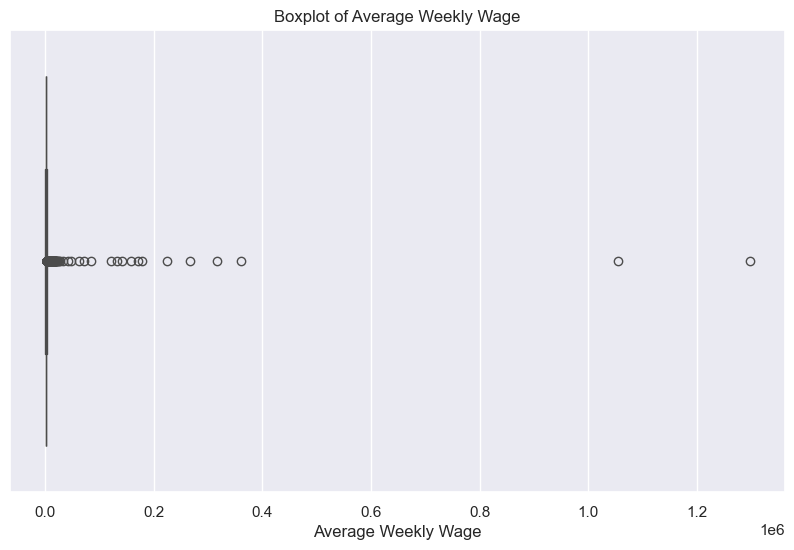

In [66]:
# Boxplot the feature 'Average Weekly Wage'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Average Weekly Wage', data=X_train)
plt.title('Boxplot of Average Weekly Wage')
plt.show()



Let's do the IQR Method and check what rows are removed.

In [67]:
# Let's apply the IQR method to remove the outliers from 'Average Weekly Wage'
Q1 = X_train['Average Weekly Wage'].quantile(0.25)
Q3 = X_train['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1

# Filter the rows that are outside of the IQR range
wage_outliers_train = X_train[(X_train['Average Weekly Wage'] < (Q1 - 1.5 * IQR)) | (X_train['Average Weekly Wage'] > (Q3 + 1.5 * IQR))]

# Do the same for the validation set
# Using the train set Q1, Q3 and IQR to avoid data leakage
wage_outliers_val = X_val[(X_val['Average Weekly Wage'] < (Q1 - 1.5 * IQR)) | (X_val['Average Weekly Wage'] > (Q3 + 1.5 * IQR))]

print(wage_outliers_train.shape)

(4799, 43)


In [68]:
# Check the 'Claim Injury Type' for the wage_outliers
print(y_train.loc[wage_outliers_train.index].value_counts())


Claim Injury Type
4. TEMPORARY       2577
5. PPD SCH LOSS    1389
3. MED ONLY         723
6. PPD NSL           88
2. NON-COMP          11
8. DEATH              6
7. PTD                4
1. CANCELLED          1
Name: count, dtype: int64


Since the target variable the IQR method's doesn't have an high impact on the target variable, we are going to remove the rows that are outside the IQR range.

In [69]:
# Filter out the wage_outliers on X_train
X_train = X_train[~X_train.index.isin(wage_outliers_train.index)]
y_train = y_train.loc[X_train.index]

# Drop with the same logic in validation set
X_val = X_val[~X_val.index.isin(wage_outliers_val.index)]
y_val = y_val.loc[X_val.index]

print("The shape of X_train after Average Weekly Wage outlier removal is: ", X_train.shape)

The shape of X_train after Average Weekly Wage outlier removal is:  (445579, 43)


### Birth Year

In [70]:
# Birth Year value counts
print(X_train['Birth Year'].value_counts().sort_index())

Birth Year
1937.0       1
1938.0       4
1939.0      30
1940.0      57
1941.0     151
          ... 
2002.0    3778
2003.0    2141
2004.0     926
2005.0     300
2006.0      53
Name: count, Length: 70, dtype: int64


In [71]:
# Check for shape of x_train and y_train
print(X_train.shape, y_train.shape)

(445579, 43) (445579,)


### C-2 Date

We've already checked for data inconsistencies before splitting the data and we've already set the threshold for accident dates. Let's check if we need to drop something.

In [72]:
# Value counts for 'C-2 Date'
print(X_train['C-2 Date'].value_counts().sort_index())

C-2 Date
2010-01-12    1
2010-01-15    1
2010-01-25    1
2010-01-27    1
2010-01-28    1
             ..
2024-05-13    1
2024-05-15    1
2024-05-17    1
2024-05-31    1
2024-06-01    1
Name: count, Length: 1736, dtype: int64


No rows dropped.

In [73]:
# Check for shape 
print("The shape of X_train before C-2 Date outlier removal is: ", X_train.shape)

The shape of X_train before C-2 Date outlier removal is:  (445579, 43)


### C-3 Date

Same as 'C-2 Date'

In [74]:
# Value counts for 'C-3 Date'
print(X_train['C-3 Date'].value_counts().sort_index())

C-3 Date
2010-08-27    1
2011-03-03    1
2011-05-26    1
2012-07-12    1
2012-11-02    1
             ..
2024-05-24    7
2024-05-28    7
2024-05-29    2
2024-05-30    3
2024-05-31    1
Name: count, Length: 1603, dtype: int64


No rows dropped.

### Carrier Name

In [75]:
# Value counts for 'Carrier Name'
print(X_train['Carrier Name'].value_counts())

Carrier Name
STATE INSURANCE FUND            86777
POLICE, FIRE, SANITATION        16596
AMERICAN ZURICH INSURANCE CO    13737
CHARTER OAK FIRE INS CO         13426
INDEMNITY INS. OF N AMERICA     11379
                                ...  
CASTLEPOINT NATIONAL INS CO         1
WAUSAU UNDERWRITERS INS CO          1
UNITED STATES FID & GUAR CO         1
EAST HAMPTON UNION FREE             1
FORT EDWARD UFSD                    1
Name: count, Length: 1432, dtype: int64


In [76]:
# Check values for 'Carrier Name' that have more than 5 counts
carrier_counts = X_train['Carrier Name'].value_counts()
carrier_counts[carrier_counts <= 10]

Carrier Name
UNION SPRINGS CSD                 10
ACE PROPERTY & CASUALTY INS CO    10
WHITESBORO CSD                    10
MIDWEST EMPLOYERS CASUALTY CO     10
BRADFORD CENTRAL SCHOOL           10
                                  ..
CASTLEPOINT NATIONAL INS CO        1
WAUSAU UNDERWRITERS INS CO         1
UNITED STATES FID & GUAR CO        1
EAST HAMPTON UNION FREE            1
FORT EDWARD UFSD                   1
Name: count, Length: 515, dtype: int64

If we were to use only OHE in encoding we might have dropped these rows to reduce the cardinality of this feature. But since we are using Frequency Encoding for high cardinality, we are not going to drop any rows.

### Carrier Type

In [77]:
# Carrier Type value counts

print(X_train['Carrier Type'].value_counts())

Carrier Type
1A. PRIVATE                                    222413
3A. SELF PUBLIC                                 92954
2A. SIF                                         86777
4A. SELF PRIVATE                                41440
UNKNOWN                                          1218
5D. SPECIAL FUND - UNKNOWN                        774
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          2
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)         1
Name: count, dtype: int64


We're going to transform the 'Unknown' values into NaN values so that we can fill them later.

In [78]:
# Transform the 'Carrier Type' 'Unknown' to NaN
X_train['Carrier Type'] = X_train['Carrier Type'].replace('Unknown', np.nan)

# Do the same for the validation set
X_val['Carrier Type'] = X_val['Carrier Type'].replace('Unknown', np.nan)

In [79]:
# Check for missing values in 'Carrier Type'
print(X_train['Carrier Type'].isnull().sum())

0


### County of Injury

In [80]:
# County of Injury value counts
print(X_train['County of Injury'].value_counts().sort_values())

County of Injury
HAMILTON        108
YATES           304
SCHOHARIE       428
MONTGOMERY      480
WYOMING         620
              ...  
BRONX         31155
NASSAU        33135
KINGS         41417
QUEENS        45273
SUFFOLK       46014
Name: count, Length: 63, dtype: int64


Since the county with the least number of occurrences has 108 occurrences, we are not going to drop any rows.

### District Name

In [81]:
# District Name value counts
print(X_train['District Name'].value_counts().sort_values())

District Name
STATEWIDE       2824
BINGHAMTON     17108
ROCHESTER      31810
SYRACUSE       34900
BUFFALO        35662
HAUPPAUGE      46089
ALBANY         67605
NYC           209581
Name: count, dtype: int64


Since there district with the least number of occurrences has 2824 occurrences, we are not going to drop any rows because thats a significant amount of data.

### First Hearing Date

In [82]:
# First Hearing Date value counts
print(X_train['First Hearing Date'].value_counts().sort_values())

First Hearing Date
2020-01-31      1
2024-01-08      2
2020-01-30      2
2020-09-17      2
2020-06-23      2
             ... 
2021-05-25    288
2020-12-21    299
2022-01-20    306
2022-04-15    319
2022-02-15    328
Name: count, Length: 1091, dtype: int64


Since we already checked for data inconsistencies before splitting the data, we are not going to drop any rows here.

### Gender

In [83]:
# Gender value counts
print(X_train['Gender'].value_counts())

Gender
M    258266
F    183704
U      3576
X        33
Name: count, dtype: int64


In [84]:
# Find the indexes of rows in X_train where the 'Gender' column has the value 'U' (unknown)
u_indexes_train = X_train[X_train['Gender'] == 'U'].index

# Find the indexes of rows in X_train where the 'Gender' column has the value 'X' (another category)
x_indexes_train = X_train[X_train['Gender'] == 'X'].index

# Find the indexes of rows in X_val (validation set) where the 'Gender' column has the value 'U' (unknown)
u_indexes_val = X_val[X_val['Gender'] == 'U'].index

# Find the indexes of rows in X_val where the 'Gender' column has the value 'X'
x_indexes_val = X_val[X_val['Gender'] == 'X'].index

# Find the indexes of rows in df_test where the 'Gender' column has the value 'U'
u_indexes_test = df_test[df_test['Gender'] == 'U'].index

# Find the indexes of rows in df_test where the 'Gender' column has the value 'X'
x_indexes_test = df_test[df_test['Gender'] == 'X'].index

# Select the target variable values (y_train) corresponding to the indexes where the 'Gender' column is 'U'
u_rows = y_train.loc[u_indexes_train]

# Value counts for the u_rows
print(u_rows.value_counts())

Claim Injury Type
2. NON-COMP        2404
4. TEMPORARY        560
3. MED ONLY         363
5. PPD SCH LOSS     131
1. CANCELLED        106
6. PPD NSL           12
Name: count, dtype: int64


In [85]:
# Select the target variable values (y_train) corresponding to the indexes where the 'Gender' column is 'X'
x_rows_train = y_train.loc[x_indexes_train]

# Extract the target variable values (y_val) corresponding to the indexes where the 'Gender' column is 'X' in the validation set
x_rows_val = y_val

# Print the value counts (frequency of each value) for the rows in y_train where the 'Gender' is 'X'
print(x_rows_train.value_counts())

Claim Injury Type
3. MED ONLY        14
2. NON-COMP         8
4. TEMPORARY        5
5. PPD SCH LOSS     4
1. CANCELLED        2
Name: count, dtype: int64


We can see that none of the most critical target variables have a significant amount of rows in 'X' and 'U'

In [86]:
# Filter out the rows in X_train where the 'Gender' is 'U' or 'X'
# ~X_train.index.isin(u_indexes_train) excludes the rows where 'Gender' is 'U'

X_train = X_train[~X_train.index.isin(u_indexes_train)]

# ~X_train.index.isin(x_indexes_train) excludes the rows where 'Gender' is 'X'
X_train = X_train[~X_train.index.isin(x_indexes_train)]

# Update y_train to keep only the target variable values corresponding to the remaining rows in X_train
y_train = y_train.loc[X_train.index]

# Similarly, filter out rows in X_val (validation set) where the 'Gender' is 'U' or 'X'

X_val = X_val[~X_val.index.isin(u_indexes_val)]
X_val = X_val[~X_val.index.isin(x_indexes_val)]

# Update y_val to keep only the target variable values corresponding to the remaining rows in X_val
y_val = y_val.loc[X_val.index]

In [87]:
print("The shape of X_train after outlier removal is: ", X_train.shape)

The shape of X_train after outlier removal is:  (441970, 43)


Transform the feature into binary

In [88]:
# Replace the 'M' (Male) and 'F' (Female) values in the 'Gender' column of X_train with 1 and 0 respectively.
X_train['Gender'] = X_train['Gender'].map({'M': 1, 'F': 0})

# Similarly, replace 'M' and 'F' with 1 and 0 in the 'Gender' column of X_val (validation set).
X_val['Gender'] = X_val['Gender'].map({'M': 1, 'F': 0})

# Do the same transformation for the 'Gender' column in the test dataset (df_test).
df_test['Gender'] = df_test['Gender'].map({'M': 1, 'F': 0})

In [89]:
# Get the unique values in the 'Gender' column of the df_test dataset
unique_genders = df_test['Gender'].unique()

# Print the unique values found in the 'Gender' column
print(f"Unique values in 'Gender' column: {unique_genders}")


Unique values in 'Gender' column: [ 1.  0. nan]


In [90]:
# Calculate the mode of the 'Gender' column
gender_mode = df_test['Gender'].mode()[0]

# Fill NaN values with the mode
df_test['Gender'].fillna(gender_mode, inplace=True)

# Verify the unique values after filling
unique_genders = df_test['Gender'].unique()
print(f"Unique values in 'Gender' column after filling NaN: {unique_genders}")


Unique values in 'Gender' column after filling NaN: [1. 0.]


### IME-4 Count

In [91]:
# IME-4 Count value counts
print(X_train['IME-4 Count'].value_counts().sort_values())

IME-4 Count
73.0        1
35.0        1
39.0        2
33.0        2
31.0        2
36.0        2
28.0        3
29.0        4
32.0        4
30.0        4
34.0        4
25.0        6
26.0        7
27.0       11
23.0       13
24.0       14
22.0       27
21.0       41
20.0       49
19.0       57
17.0       86
18.0      108
16.0      163
15.0      222
14.0      303
13.0      387
12.0      620
11.0      768
10.0     1131
9.0      1470
8.0      2466
7.0      3013
6.0      5037
5.0      5910
4.0     10652
3.0     12362
2.0     26460
1.0     30425
Name: count, dtype: int64


In [92]:
# Filter rows in X_train where the 'IME-4 Count' is greater than 20
ime_outliers_train = X_train[X_train['IME-4 Count'] > 20]

# Filter rows in X_val where the 'IME-4 Count' is greater than 20
ime_outliers_val = X_val[X_val['IME-4 Count'] > 20]

print(y_train.loc[ime_outliers_train.index].value_counts())

Claim Injury Type
4. TEMPORARY       142
6. PPD NSL           3
3. MED ONLY          2
5. PPD SCH LOSS      1
Name: count, dtype: int64


Since there are no critical target variables with a significant amount of rows above 'IME-4 Count' above of 20, we are dropping the rows with 'IME-4 Count' above 20.

In [93]:
# Filter out the rows in X_train where the 'IME-4 Count' is greater than 20
X_train = X_train[~X_train.index.isin(ime_outliers_train.index)]

# Update y_train to keep only the target variable values corresponding to the remaining rows in X_train
y_train = y_train.loc[X_train.index]

# Similarly, filter out rows in X_val (validation set) where the 'IME-4 Count' is greater than 20
X_val = X_val[~X_val.index.isin(ime_outliers_val.index)]

# Update y_val to keep only the target variable values corresponding to the remaining rows in X_val
y_val = y_val.loc[X_val.index]

### Industry Code / Description

In [94]:
# Industy_code value counts
print(X_train['Industry Code'].value_counts().sort_values())

Industry Code
55.0      262
21.0      538
11.0     1884
22.0     2028
52.0     6273
51.0     6818
53.0     6931
54.0     7491
71.0     7749
31.0     7847
32.0     8321
81.0    10286
42.0    11887
49.0    12492
33.0    13417
45.0    14046
56.0    16298
72.0    20674
23.0    23729
48.0    28393
44.0    34272
61.0    34830
92.0    69916
62.0    88964
Name: count, dtype: int64


No industry codes will be dropped

### Medical Fee Region

In [95]:
# Medical Fee Region value counts
print(X_train['Medical Fee Region'].value_counts().sort_values())

Medical Fee Region
UK      24935
III     40913
II      66119
I      105717
IV     204138
Name: count, dtype: int64


In [96]:
# Medical fee region missing values
print(X_train['Medical Fee Region'].isnull().sum())

0


We are going to transform the 'Unknown' values into NaN values so that we can fill them later.

In [97]:
# Tranfrom the unknown values to NaN
X_train['Medical Fee Region'] = X_train['Medical Fee Region'].replace('UK', np.nan)

# Do the same for the validation set
X_val['Medical Fee Region'] = X_val['Medical Fee Region'].replace('UK', np.nan)

### WCIO Cause of Injury Code / Description

In [98]:
# WCIO Cause of Injury Code value counts
print(X_train['WCIO Cause of Injury Code'].value_counts().sort_values())

WCIO Cause of Injury Code
47.0       10
8.0        23
40.0       34
14.0       42
91.0       42
        ...  
29.0    22857
31.0    24661
60.0    25657
74.0    29052
56.0    36303
Name: count, Length: 77, dtype: int64


No dropped rows since the least frequent cause of injury has 10 occurrence.

### WCIO Nature of Injury Code / Description

In [99]:
# WCIO Nature of Injury Code value counts
print(X_train['WCIO Nature of Injury Code'].value_counts().sort_values())

WCIO Nature of Injury Code
63.0         1
76.0         3
79.0         3
62.0         5
22.0         6
70.0        10
64.0        10
67.0        20
75.0        21
30.0        49
60.0        50
61.0        61
54.0        67
74.0        85
55.0       119
3.0        142
38.0       156
58.0       208
66.0       228
91.0       266
47.0       276
42.0       319
32.0       336
69.0       346
41.0       348
19.0       477
72.0       490
73.0       556
2.0        584
36.0       735
68.0       827
46.0       951
65.0       960
31.0      1051
71.0      1065
53.0      1123
77.0      1209
78.0      1807
80.0      1980
34.0      2110
13.0      4120
7.0       4291
16.0      4552
1.0       4662
25.0      5834
4.0       5909
37.0      9712
90.0      9738
43.0     13578
28.0     17567
83.0     19171
59.0     27988
40.0     36893
49.0     43357
10.0     86334
52.0    118969
Name: count, dtype: int64


In [100]:
# Get the list of 'WCIO Nature of Injury Code' values in X_train that appear less than 10 times
code_list_train = X_train['WCIO Nature of Injury Code'].value_counts()[X_train['WCIO Nature of Injury Code'].value_counts() < 10].index

# Get the list of 'WCIO Nature of Injury Code' values in X_val that appear less than 10 times
code_list_val = X_val['WCIO Nature of Injury Code'].value_counts()[X_val['WCIO Nature of Injury Code'].value_counts() < 10].index

# Get the indexes in X_train where 'WCIO Nature of Injury Code' is in the list of codes with less than 10 occurrences
wcio_nature_idxs_train = X_train[X_train['WCIO Nature of Injury Code'].isin(code_list_train)].index

# Get the indexes in X_val where 'WCIO Nature of Injury Code' is in the list of codes with less than 10 occurrences
wcio_nature_idxs_val = X_val[X_val['WCIO Nature of Injury Code'].isin(code_list_val)].index

print(y_train.loc[wcio_nature_idxs_train].value_counts())


Claim Injury Type
4. TEMPORARY    10
2. NON-COMP      6
3. MED ONLY      2
Name: count, dtype: int64


We'll drop the codes with less than 10 occurrences.

In [101]:
# Dropping the rows that have 'WCIO Nature of Injury Code' that are less than 10
X_train = X_train[~X_train.index.isin(wcio_nature_idxs_train)]
y_train = y_train.loc[X_train.index]

# Drop with the same logic in validation set
X_val = X_val[~X_val.index.isin(wcio_nature_idxs_val)]
y_val = y_val.loc[X_val.index]

### WCIO Part Of Body Code / Description

In [102]:
# WCIO Part Of Body Code value counts

print(X_train['WCIO Part Of Body Code'].value_counts().sort_index())

WCIO Part Of Body Code
10.0     6111
11.0     6208
12.0     1561
13.0     2357
14.0    10250
15.0     1614
16.0      626
17.0     1252
18.0    10791
19.0     3071
20.0     2166
21.0     1038
22.0      844
23.0      375
24.0      116
25.0     4607
26.0       63
30.0     2004
31.0     8702
32.0     7662
33.0    11904
34.0    14427
35.0    24306
36.0    28302
37.0     9823
38.0    29318
39.0     1922
40.0     1332
41.0     6373
42.0    40643
43.0     1497
44.0     5988
45.0      317
46.0      548
47.0      320
48.0     2706
49.0      465
50.0     1467
51.0     4995
52.0     3347
53.0    37169
54.0     9050
55.0    19471
56.0    14605
57.0     1989
58.0     1415
60.0    10577
61.0     5296
62.0      938
63.0     1543
64.0       41
65.0     3947
66.0     4723
90.0    17266
91.0     8274
99.0      821
Name: count, dtype: int64


### Zip Code

In [103]:
# Zip Code value counts
print(X_train['Zip Code'].value_counts().sort_values())

Zip Code
46322       1
79904       1
77034       1
29532       1
77598       1
         ... 
11706    2112
11434    2120
11717    2231
10940    2337
11236    2522
Name: count, Length: 7317, dtype: int64


We've already checked for data inconsistencies before splitting the data, we are not going to drop any rows here.

### Number of Dependents

In [104]:
# Value counts for 'Number of Dependents'
print(X_train['Number of Dependents'].value_counts().sort_index())

Number of Dependents
0.0    62956
1.0    62880
2.0    62778
3.0    63372
4.0    63163
5.0    63118
6.0    63537
Name: count, dtype: int64


No rows will be dropped.

## Missing Values:

- Accident Date 
- Average Weekly Wage
- Birth Year
- C-2 Date
- C-3 Date
- First Hearing Date
- IME-4 Count
- Industry Code
- Industry Code Description
- WCIO Cause of Injury Code
- WCIO Cause of Injury Description
- WCIO Nature of Injury Code
- WCIO Nature of Injury Description
- WCIO Part Of Body Code
- WCIO Part Of Body Description
- Zip Code

Let's fill it from the least to the most missing values.

### Accident Date

Accident Value: This feature is highly correlated with the Assembly Date and the C-2 Date. Since Assembly Date has less missing values, we're going to assume it's more reliable and fill the missing values with the Assembly Date.

In [105]:
# Check the number of rows in X_train where 'Accident Date' has missing values (NaN)
print("There are {} rows with missing Accident Date values".format(X_train['Accident Date'].isna().sum()))

# Save the indexes of the rows with missing 'Accident Date' values for comparison later
missing_accident_date_idxs = X_train[X_train['Accident Date'].isna()].index

There are 0 rows with missing Accident Date values


In [106]:
# Calculate the difference in days between 'Accident Date' and 'Assembly Date' columns
# The .dt.days attribute extracts the difference in days
X_train['diff_accident_assembly'] = (X_train['Accident Date'] - X_train['Assembly Date']).dt.days

# Calculate and round the mean of the differences in 'diff_accident_assembly', skipping NaN values
mean_diff_assembly = round(X_train['diff_accident_assembly'].mean(skipna=True),0)

print(f"Mean difference (Assembly): {mean_diff_assembly}")


Mean difference (Assembly): -43.0


In [107]:
# We are using this function to help us impute the missing values in the Date type columns

def impute_missing_dates(target_df, target_column, reference_columns):
    """
    Generalized function to impute missing dates based on the mean difference between target and reference columns.

    Parameters:
        target_df (pd.DataFrame): The dataset where imputation is applied.
        target_column (str): The name of the column with missing dates to be imputed.
        reference_columns (list of str): List of columns to calculate mean differences with the target column.

    Returns:
        pd.DataFrame: The dataset with missing values in the target column imputed.
    """
    import numpy as np

    # Ensure all reference columns and target column are in datetime format
    for col in [target_column] + reference_columns:
        target_df[col] = pd.to_datetime(target_df[col], errors='coerce')

    # Calculate mean differences for each reference column
    mean_differences = {}
    for ref_col in reference_columns:
        # Compute the mean difference (in days) between the target column and the reference column
        valid_diff = (target_df[target_column] - target_df[ref_col]).dt.days.dropna()
        mean_differences[ref_col] = round(valid_diff.mean(), 0)

    print(f"Mean differences (in days): {mean_differences}")

    # Impute missing values in the target column
    def impute_row(row):
        # If target_column is not missing, keep the existing value
        if pd.notna(row[target_column]):
            return row[target_column]

        # Attempt to impute using reference columns
        for ref_col in reference_columns:
            if pd.notna(row[ref_col]):  # Check if reference column has a value
                return row[ref_col] + pd.Timedelta(days=mean_differences[ref_col])

        # If no imputation is possible, leave as NaT
        return np.nan

    # Apply the imputation logic
    target_df[target_column] = target_df.apply(impute_row, axis=1)

    return target_df

In [108]:
# Ensure 'Assembly Date' is in datetime format
X_val['Assembly Date'] = pd.to_datetime(X_val['Assembly Date'], errors='coerce')
df_test['Assembly Date'] = pd.to_datetime(df_test['Assembly Date'], errors='coerce')

mean_diff_assembly = round((X_train['Accident Date'] - X_train['Assembly Date']).dt.days.mean(),0)
print(f"Mean difference (in days): {mean_diff_assembly}")

def impute_accident_date(target_df, mean_diff_assembly):
    """
    Impute missing values in the 'Accident Date' column based on the mean difference from 'Assembly Date'.
    
    Parameters:
        target_df (pd.DataFrame): The dataset (training, validation, or test) where imputation is applied.
        mean_diff_assembly (int): The mean difference in days between 'Assembly Date' and 'Accident Date'.
    
    Returns:
        pd.DataFrame: The dataset with missing values in 'Accident Date' imputed.
    """
    target_df['Accident Date'] = target_df.apply(
        lambda row: row['Assembly Date'] + pd.Timedelta(days=mean_diff_assembly)
        if pd.isna(row['Accident Date']) else row['Accident Date'],
        axis=1
    )
    return target_df

Mean difference (in days): -43.0


In [109]:
# Impute the missing 'Accident Date' values in the X_train, X_val, and df_test datasets
# The 'impute_accident_date' function is applied to each dataset, using the calculated mean difference (mean_diff_assembly)
X_train = impute_accident_date(X_train, mean_diff_assembly)
X_val = impute_accident_date(X_val, mean_diff_assembly)
df_test = impute_accident_date(df_test, mean_diff_assembly)

In [110]:
# Display the first few rows in X_train that had missing 'Accident Date' values before the imputation 
X_train.loc[missing_accident_date_idxs].head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,First Hearing Date_year,First Hearing Date_month,First Hearing Date_day,C-2 Date_year,C-2 Date_month,C-2 Date_day,C-3 Date_year,C-3 Date_month,C-3 Date_day,diff_accident_assembly
Claim Identifier,,,,,,,,,,,,,,,,,,,,,


### C-2 Date

In [111]:
# Imput the missing values of 'C-2 Date' based on the 'Assembly Date'
X_train['diff_assembly_c2'] = (X_train['Assembly Date'] - X_train['C-2 Date']).dt.days

# Check the mean differences
mean_diff_c2 = round(X_train['diff_assembly_c2'].mean(skipna=True),0)

print(f"Mean difference (C-2): {mean_diff_c2}")

Mean difference (C-2): -4.0


In [112]:
def impute_c2_date(target_df, mean_diff_c2):
    """
    Impute missing values in 'C-2 Date' based on 'Assembly Date' and the mean temporal difference.
    
    Parameters:
        target_df (pd.DataFrame): The dataset (training, validation, or test) where imputation is applied.
        mean_diff_c2 (int): The mean difference (in days) between 'C-2 Date' and 'Assembly Date'.
    
    Returns:
        pd.DataFrame: The target dataset with missing values in 'C-2 Date' imputed.
    """
    # Apply the imputation logic row-wise
    target_df['C-2 Date'] = target_df.apply(
        lambda row: row['Assembly Date'] - pd.Timedelta(days=mean_diff_c2)
        if pd.isna(row['C-2 Date']) else row['C-2 Date'],
        axis=1
    )
    
    return target_df

# Impute 'C-2 Date' in the training set
X_train = impute_c2_date(X_train, mean_diff_c2)
X_val = impute_c2_date(X_val, mean_diff_c2)
df_test = impute_c2_date(df_test, mean_diff_c2)

In [113]:
# C-2 missing values 
X_train['C-2 Date'].isna().sum()

0

In [114]:
X_val['C-2 Date'].isna().sum()

0

In [115]:
df_test['C-2 Date'].isna().sum()

0

In [116]:
X_train.loc[missing_accident_date_idxs].head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,First Hearing Date_month,First Hearing Date_day,C-2 Date_year,C-2 Date_month,C-2 Date_day,C-3 Date_year,C-3 Date_month,C-3 Date_day,diff_accident_assembly,diff_assembly_c2
Claim Identifier,,,,,,,,,,,,,,,,,,,,,


In [117]:
print(X_train.isna().sum().sort_values())

Accident Date                             0
diff_accident_assembly                    0
Accident Date_month                       0
Accident Date_day                         0
Assembly Date_year                        0
Assembly Date_month                       0
Gender                                    0
Assembly Date_day                         0
District Name                             0
Accident Date_year                        0
County of Injury                          0
COVID-19 Indicator                        0
Carrier Name                              0
C-2 Date                                  0
Attorney/Representative                   0
Assembly Date                             0
Age at Injury                             0
Carrier Type                              0
Number of Dependents                      0
Alternative Dispute Resolution            5
Industry Code                          6476
Industry Code Description              6476
C-2 Date_year                   

In [118]:
X_train.drop(columns=date_components, inplace=True)

In [119]:
# Ensure 'C-2 Date' is in datetime format
X_train['C-2 Date'] = pd.to_datetime(X_train['C-2 Date'], errors='coerce')
X_val['C-2 Date'] = pd.to_datetime(X_val['C-2 Date'], errors='coerce')
df_test['C-2 Date'] = pd.to_datetime(df_test['C-2 Date'], errors='coerce')

# Create new features 'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day' because they will be used up ahead for Industry Code Imputation
X_train['C-2 Date_year'] = X_train['C-2 Date'].dt.year
X_val['C-2 Date_year'] = X_val['C-2 Date'].dt.year
df_test['C-2 Date_year'] = df_test['C-2 Date'].dt.year


In [120]:
print(X_train.isna().sum().sort_values())

Accident Date                             0
diff_accident_assembly                    0
Number of Dependents                      0
District Name                             0
COVID-19 Indicator                        0
County of Injury                          0
Carrier Type                              0
Carrier Name                              0
Gender                                    0
C-2 Date                                  0
Age at Injury                             0
Assembly Date                             0
C-2 Date_year                             0
Attorney/Representative                   0
Alternative Dispute Resolution            5
Industry Code                          6476
Industry Code Description              6476
diff_assembly_c2                       9454
WCIO Cause of Injury Description      10077
WCIO Cause of Injury Code             10077
WCIO Nature of Injury Code            10087
WCIO Nature of Injury Description     10087
WCIO Part Of Body Description   

### Industry Code and Industry Code Description

In [121]:
def imputer_function(df_train, df_target, feature_to_fill, features_to_be_based_on):
    """
    Impute missing values in a specified feature using context from other grouping features.

    Parameters:
        df_train (pd.DataFrame): The training dataset to calculate modes.
        df_target (pd.DataFrame): The dataset to which imputation is applied (e.g., validation or test).
        feature_to_fill (str): The name of the feature to impute missing values.
        features_to_be_based_on (list): A list of features to use for group-based imputation.

    Returns:
        pd.DataFrame: The target dataset with imputed values.
    """
    # Calculate modes based on grouping features
    group_modes = df_train.groupby(features_to_be_based_on)[feature_to_fill].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None
    ).to_dict()  # Ensure it's a dictionary for .get()
    
    global_modes = df_train.groupby(features_to_be_based_on[-1:])[feature_to_fill].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None
    ).to_dict()  # Ensure it's a dictionary for .get()
    
    overall_mode = (
        df_train[feature_to_fill].mode().iloc[0]
        if not df_train[feature_to_fill].mode().empty
        else None
    )  # Handle edge case for empty modes

    # Define the row-wise imputation logic
    def impute_row(row):
        if pd.isna(row[feature_to_fill]):
            # Try group-based mode
            group_values = tuple(row[feature] for feature in features_to_be_based_on)
            group_mode = group_modes.get(group_values, None)
            if group_mode is not None:
                return group_mode

            # Try global mode
            global_value = tuple(row[feature] for feature in features_to_be_based_on[-1:])
            global_mode = global_modes.get(global_value, None)
            if global_mode is not None:
                return global_mode

            # Fallback to overall mode
            return overall_mode
        
        return row[feature_to_fill]

    # Apply the imputation logic to the target dataset
    df_target[feature_to_fill] = df_target.apply(impute_row, axis=1)
    if df_target[feature_to_fill].isna().sum() > 0:
        df_target[feature_to_fill].fillna(overall_mode, inplace=True)

    return df_target

In [122]:
def impute_with_mapping(train_df, target_df, key_column, value_column):
    """
    Impute missing values in a target column based on a mapping derived from another column.

    Parameters:
        train_df (pd.DataFrame): The training dataset used to build the mapping.
        target_df (pd.DataFrame): The dataset to which imputation is applied (e.g., validation or test).
        key_column (str): The column used as the key for the mapping (e.g., 'Industry Code').
        value_column (str): The column where missing values will be imputed (e.g., 'Industry Code Description').

    Returns:
        pd.DataFrame: The target dataset with missing values imputed.
    """
    # Build the mapping from key_column to value_column
    value_mapping = train_df.groupby(key_column)[value_column].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()
    
    # Define the imputation function
    def impute_row(row):
        if pd.isna(row[value_column]) and row[key_column] in value_mapping:
            return value_mapping[row[key_column]]
        return row[value_column]
    
    # Apply the imputation function to the target dataset
    target_df[value_column] = target_df.apply(impute_row, axis=1)
    
    return target_df

In [123]:
#TODO We need to justify from what value we consider 'high correlation' for the features. Carrier Name s 0.48 with Industry Code and C-2 Date_year is 0.70 with Industry Code
# Impute 'Industry Code' in the training, validation, and test sets
X_train = imputer_function(X_train, X_train, 'Industry Code', ['C-2 Date_year', 'Carrier Name'])
X_val = imputer_function(X_train, X_val, 'Industry Code', ['C-2 Date_year', 'Carrier Name'])
df_test = imputer_function(X_train, df_test, 'Industry Code', ['C-2 Date_year', 'Carrier Name'])

In [124]:
#Missing values in 'Industry Code' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['Industry Code'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['Industry Code'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['Industry Code'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


In [125]:
# Apply the imputation function to the training set
X_train = impute_with_mapping(X_train, X_train, 'Industry Code', 'Industry Code Description')
X_val = impute_with_mapping(X_train, X_val, 'Industry Code', 'Industry Code Description')
df_test = impute_with_mapping(X_train, df_test, 'Industry Code', 'Industry Code Description')

In [126]:
#Missing values for 'Industry Code Description' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['Industry Code Description'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['Industry Code Description'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['Industry Code Description'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


### WCIO Cause of Injury Code and WCIO Cause of Injury Description

This feature is highly correlated with COVID-19 Indicator and C-2 Date_year.

In [127]:
# Apply the imputation function to the training set
X_train = imputer_function(X_train, X_train, 'WCIO Cause of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])
X_val = imputer_function(X_train, X_val, 'WCIO Cause of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])
df_test = imputer_function(X_train, df_test, 'WCIO Cause of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])

In [128]:
# Check missing values for 'WCIO Cause of Injury Code' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['WCIO Cause of Injury Code'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Cause of Injury Code'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Cause of Injury Code'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


In [129]:
# Fill the missing 'WCIO Cause of Injury Description' with the mappings
X_train = impute_with_mapping(X_train, X_train, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')
X_val = impute_with_mapping(X_train, X_val, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')
df_test = impute_with_mapping(X_train, df_test, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')

In [130]:
# Check the missing values for 'WCIO Cause of Injury Description' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['WCIO Cause of Injury Description'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Cause of Injury Description'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Cause of Injury Description'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


### WCIO Nature of Injury Code and WCIO Nature of Injury Description

This feature is highly correlated with COVID-19 Indicator and C-2 Date_year.

In [131]:
# Apply the imputation function
X_train = imputer_function(X_train, X_train, 'WCIO Nature of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])
X_val = imputer_function(X_train, X_val, 'WCIO Nature of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])
df_test = imputer_function(X_train, df_test, 'WCIO Nature of Injury Code', ['COVID-19 Indicator', 'C-2 Date_year'])

In [132]:
#Check missing values for 'WCIO Nature of Injury Code' in each dataset

print("There are {} missing values in X_train dataset.".format(X_train['WCIO Nature of Injury Code'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Nature of Injury Code'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Nature of Injury Code'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


In [133]:
# Apply the imputation function with mapping
X_train = impute_with_mapping(X_train, X_train, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')
X_val = impute_with_mapping(X_train, X_val, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')
df_test = impute_with_mapping(X_train, df_test, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')

In [134]:
# Check missing values for 'WCIO Nature of Injury Description' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['WCIO Nature of Injury Description'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Nature of Injury Description'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Nature of Injury Description'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


In [135]:
# Check for missing values 
print(X_train.isna().sum().sort_values())

Accident Date                             0
diff_accident_assembly                    0
Number of Dependents                      0
WCIO Nature of Injury Description         0
WCIO Nature of Injury Code                0
WCIO Cause of Injury Description          0
WCIO Cause of Injury Code                 0
Industry Code Description                 0
Industry Code                             0
District Name                             0
COVID-19 Indicator                        0
Gender                                    0
Carrier Type                              0
Age at Injury                             0
Assembly Date                             0
Attorney/Representative                   0
County of Injury                          0
C-2 Date                                  0
C-2 Date_year                             0
Carrier Name                              0
Alternative Dispute Resolution            5
diff_assembly_c2                       9454
WCIO Part Of Body Description   

### WCIO Part Of Body Code and WCIO Part Of Body Description

This feature is highly correlated with COVID-19 Indicator and C-2 Date_year.

In [136]:
# Apply the imputation function
X_train = imputer_function(X_train, X_train, 'WCIO Part Of Body Code', ['COVID-19 Indicator', 'C-2 Date_year'])
X_val = imputer_function(X_train, X_val, 'WCIO Part Of Body Code', ['COVID-19 Indicator', 'C-2 Date_year'])
df_test = imputer_function(X_train, df_test, 'WCIO Part Of Body Code', ['COVID-19 Indicator', 'C-2 Date_year'])


In [137]:
#Check missing values for 'WCIO Part Of Body Code' in each dataset

print("There are {} missing values in X_train dataset.".format(X_train['WCIO Part Of Body Code'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Part Of Body Code'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Part Of Body Code'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


In [138]:
# Apply the imputation function with mapping
X_train = impute_with_mapping(X_train, X_train, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')
X_val = impute_with_mapping(X_train, X_val, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')
df_test = impute_with_mapping(X_train, df_test, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')

In [139]:
#Check missing values for 'WCIO Part Of Body Description' in each dataset

print("There are {} missing values in X_train dataset.".format(X_train['WCIO Part Of Body Description'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['WCIO Part Of Body Description'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['WCIO Part Of Body Description'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


### Zip code

In [140]:
# Apply the imputation function
imputer_function(X_train, X_train, 'Zip Code', ['Medical Fee Region','County of Injury', 'District Name'])
imputer_function(X_train, X_val, 'Zip Code', ['Medical Fee Region','County of Injury', 'District Name'])
imputer_function(X_train, df_test, 'Zip Code', ['Medical Fee Region','County of Injury', 'District Name'])

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,C-2 Date_year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,2022-12-24,19,0.0,2023-01-02,0,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,...,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1,2023
6166141,2022-11-20,19,0.0,2023-01-02,0,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,...,IV,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1,2023
6165907,2022-12-26,59,0.0,2023-01-02,0,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,...,III,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0,2022
6166047,2022-12-28,55,0.0,2023-01-02,0,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,...,IV,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6,2023
6166102,2022-12-20,25,0.0,2023-01-02,0,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,IV,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553137,2012-09-12,52,0.0,2024-06-05,0,NaN,1960.0,2012-10-23,NaN,STATE INSURANCE FUND,...,I,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,13619,5,2012
6553119,2024-05-22,59,0.0,2024-06-05,1,0.0,1965.0,2024-06-09,2024-05-28,NYC TRANSIT AUTHORITY,...,IV,57.0,PUSHING OR PULLING,10.0,CONTUSION,42.0,LOWER BACK AREA,11776,1,2024
6553542,2024-05-06,45,0.0,2024-06-05,1,0.0,1979.0,2024-06-09,NaN,STATE INSURANCE FUND,...,IV,57.0,PUSHING OR PULLING,10.0,CONTUSION,42.0,LOWER BACK AREA,11368,5,2024


In [141]:
#Check missing values for 'Zip Code' in each dataset

print("There are {} missing values in X_train dataset.".format(X_train['Zip Code'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['Zip Code'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['Zip Code'].isna().sum()))

There are 0 missing values in X_train dataset.
There are 0 missing values in X_val dataset.
There are 0 missing values in df_test dataset.


### Medical Fee Region

In [142]:
#Check for missing values
print(X_train.isna().sum().sort_values())

Accident Date                             0
diff_accident_assembly                    0
Number of Dependents                      0
Zip Code                                  0
WCIO Part Of Body Description             0
WCIO Part Of Body Code                    0
WCIO Nature of Injury Description         0
WCIO Nature of Injury Code                0
WCIO Cause of Injury Description          0
WCIO Cause of Injury Code                 0
Industry Code Description                 0
Industry Code                             0
District Name                             0
Gender                                    0
C-2 Date                                  0
Age at Injury                             0
Assembly Date                             0
Attorney/Representative                   0
COVID-19 Indicator                        0
Carrier Name                              0
C-2 Date_year                             0
Carrier Type                              0
County of Injury                

In [143]:
imputer_function(X_train, X_train, 'Medical Fee Region', ['County of Injury', 'Zip Code'])
imputer_function(X_train, X_val, 'Medical Fee Region', ['County of Injury', 'Zip Code'])
imputer_function(X_train, df_test, 'Medical Fee Region', ['County of Injury', 'Zip Code'])

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,C-2 Date_year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,2022-12-24,19,0.0,2023-01-02,0,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,...,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1,2023
6166141,2022-11-20,19,0.0,2023-01-02,0,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,...,IV,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1,2023
6165907,2022-12-26,59,0.0,2023-01-02,0,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,...,III,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0,2022
6166047,2022-12-28,55,0.0,2023-01-02,0,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,...,IV,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6,2023
6166102,2022-12-20,25,0.0,2023-01-02,0,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,IV,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553137,2012-09-12,52,0.0,2024-06-05,0,NaN,1960.0,2012-10-23,NaN,STATE INSURANCE FUND,...,I,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,13619,5,2012
6553119,2024-05-22,59,0.0,2024-06-05,1,0.0,1965.0,2024-06-09,2024-05-28,NYC TRANSIT AUTHORITY,...,IV,57.0,PUSHING OR PULLING,10.0,CONTUSION,42.0,LOWER BACK AREA,11776,1,2024
6553542,2024-05-06,45,0.0,2024-06-05,1,0.0,1979.0,2024-06-09,NaN,STATE INSURANCE FUND,...,IV,57.0,PUSHING OR PULLING,10.0,CONTUSION,42.0,LOWER BACK AREA,11368,5,2024


### Alternative Dispute Resolution

In [144]:
#Save the indexes of the missing values in 'Alternative Dispute Resolution' to compare after the imputation
missing_adr_idxs = X_train[X_train['Alternative Dispute Resolution'].isna()].index

#Check them rows
X_train.loc[missing_adr_idxs].head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,diff_accident_assembly,diff_assembly_c2,C-2 Date_year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6108701,2022-09-01,57.0,NaN,2022-10-17,0,NaN,1965.0,2022-10-21,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11755,0.0,-46,NaN,2022
6032724,2021-11-05,56.0,NaN,2022-07-11,0,NaN,1965.0,2022-07-15,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10595,5.0,-248,NaN,2022
5582402,2018-03-12,57.0,NaN,2020-10-21,0,NaN,1961.0,2020-10-25,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10301,5.0,-954,NaN,2020
6034607,2022-07-06,52.0,NaN,2022-07-13,1,NaN,1969.0,2022-07-17,2023-03-09,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11694,5.0,-7,NaN,2022
6108690,2022-08-29,55.0,NaN,2022-10-17,0,NaN,1967.0,2022-10-21,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11743,6.0,-49,NaN,2022


In [145]:
# Apply the imputation function
X_train = imputer_function(X_train, X_train, 'Alternative Dispute Resolution', ['Carrier Name'])
X_val = imputer_function(X_train, X_val, 'Alternative Dispute Resolution', ['Carrier Name'])
df_test = imputer_function(X_train, df_test, 'Alternative Dispute Resolution', ['Carrier Name'])

In [146]:
X_train.loc[missing_adr_idxs].head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,diff_accident_assembly,diff_assembly_c2,C-2 Date_year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6108701,2022-09-01,57.0,0.0,2022-10-17,0,NaN,1965.0,2022-10-21,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11755,0.0,-46,NaN,2022
6032724,2021-11-05,56.0,0.0,2022-07-11,0,NaN,1965.0,2022-07-15,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10595,5.0,-248,NaN,2022
5582402,2018-03-12,57.0,0.0,2020-10-21,0,NaN,1961.0,2020-10-25,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10301,5.0,-954,NaN,2020
6034607,2022-07-06,52.0,0.0,2022-07-13,1,NaN,1969.0,2022-07-17,2023-03-09,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11694,5.0,-7,NaN,2022
6108690,2022-08-29,55.0,0.0,2022-10-17,0,NaN,1967.0,2022-10-21,NaT,ELECTRICAL EMPLOYERS,...,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11743,6.0,-49,NaN,2022


In [147]:
# Calculate the total number of missing values in each column of the training set (X_train)
missing_values = X_train.isna().sum().sort_values(ascending=False)

# Calculate the percentage of missing values for each column in X_train by dividing missing values by the total number of rows (len(X_train)) and multiplying by 100
missing_values_percentage = (missing_values / len(X_train)) * 100

print(missing_values_percentage)



IME-4 Count                          76.984817
First Hearing Date                   74.064517
C-3 Date                             68.034920
Average Weekly Wage                  63.653792
Birth Year                            5.080307
diff_assembly_c2                      2.139863
Accident Date                         0.000000
WCIO Nature of Injury Description     0.000000
WCIO Cause of Injury Code             0.000000
WCIO Cause of Injury Description      0.000000
WCIO Nature of Injury Code            0.000000
WCIO Part Of Body Description         0.000000
WCIO Part Of Body Code                0.000000
Industry Code Description             0.000000
Zip Code                              0.000000
Number of Dependents                  0.000000
diff_accident_assembly                0.000000
Medical Fee Region                    0.000000
Gender                                0.000000
Industry Code                         0.000000
Age at Injury                         0.000000
District Name

Considerations for Handling Missing Values:

IME-4 Count:

- Should missing values be imputed with a value of 0, indicating no occurrence of the event?
- Alternatively, could we apply an imputation method using the mode of the corresponding group to fill missing values?
- Another option would be to transform this feature into a binary variable, where a value of 1 indicates the presence of at least one form and 0 indicates no form.
  
C-3 Date:

- Should the missing values be handled similarly to how we processed the C-2 Date and Accident Date, possibly by using interpolation or forward filling?
- Another possibility is converting this feature into a binary variable, where 1 indicates the occurrence of an event and 0 signifies no event.
  
First Hearing Date:

- Should we treat this variable as binary, where a value of 1 indicates that a hearing took place and 0 indicates that no hearing occurred?
  
Average Weekly Wage:

- Could we apply K-Nearest Neighbors (KNN) imputation to fill in the missing values based on similar instances?

Birth Year:

- Similarly, should we impute missing values for the Birth Year feature using KNN, considering the relationships between other features?

### IME-4 Count

In [148]:
# Fill the missing values of 'IME-4 Count' with 0
X_train['IME-4 Count'] = X_train['IME-4 Count'].fillna(0)
X_val['IME-4 Count'] = X_val['IME-4 Count'].fillna(0)
df_test['IME-4 Count'] = df_test['IME-4 Count'].fillna(0)

### First Hearing Date

In [149]:
# Transform this feature into binary. If there is 'First Hearing Date' then it is 1, otherwise 0
X_train['First Hearing Date'] = X_train['First Hearing Date'].apply(lambda x: 1 if pd.notna(x) else 0)
X_val['First Hearing Date'] = X_val['First Hearing Date'].apply(lambda x: 1 if pd.notna(x) else 0)
df_test['First Hearing Date'] = df_test['First Hearing Date'].apply(lambda x: 1 if pd.notna(x) else 0)

### C-3 Date

In [150]:
# Transform this feature into binary. If there is 'C-3 Date' then it is 1, otherwise 0
X_train['C-3 Date'] = X_train['C-3 Date'].apply(lambda x: 1 if pd.notna(x) else 0)
X_val['C-3 Date'] = X_val['C-3 Date'].apply(lambda x: 1 if pd.notna(x) else 0)
df_test['C-3 Date'] = df_test['C-3 Date'].apply(lambda x: 1 if pd.notna(x) else 0)

In [151]:
#check misisng values
print(X_train.isna().sum().sort_values())

Accident Date                             0
diff_accident_assembly                    0
Number of Dependents                      0
Zip Code                                  0
WCIO Part Of Body Description             0
WCIO Part Of Body Code                    0
WCIO Nature of Injury Description         0
WCIO Nature of Injury Code                0
WCIO Cause of Injury Description          0
WCIO Cause of Injury Code                 0
Medical Fee Region                        0
Industry Code Description                 0
Industry Code                             0
IME-4 Count                               0
Gender                                    0
District Name                             0
COVID-19 Indicator                        0
County of Injury                          0
Carrier Type                              0
Carrier Name                              0
C-3 Date                                  0
C-2 Date                                  0
Attorney/Representative         

In [152]:
print(df_test.shape)

(387975, 29)


### Birth Year and Average Weekly Wage

In [ ]:
# Define the numerical features to impute
numerical_features = ['Birth Year', 'Average Weekly Wage']

# Normalize numerical features
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Define the KNN imputer
knn_imputer = KNNImputer(n_neighbors=3)

# Apply KNN imputation on scaled numerical features
X_train_scaled[numerical_features] = knn_imputer.fit_transform(X_train_scaled[numerical_features])
X_val_scaled = X_val.copy()
X_val_scaled[numerical_features] = knn_imputer.transform(scaler.transform(X_val[numerical_features]))
df_test_scaled = df_test.copy()
df_test_scaled[numerical_features] = knn_imputer.transform(scaler.transform(df_test[numerical_features]))

# Reverse scaling for imputed values
X_train[numerical_features] = scaler.inverse_transform(X_train_scaled[numerical_features])
X_val[numerical_features] = scaler.inverse_transform(X_val_scaled[numerical_features])
df_test[numerical_features] = scaler.inverse_transform(df_test_scaled[numerical_features])

In [ ]:
# Check missing values for 'Birth Year' and 'Average Weekly Wage' in each dataset
print("There are {} missing values in X_train dataset.".format(X_train['Birth Year'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['Birth Year'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['Birth Year'].isna().sum()))

print("There are {} missing values in X_train dataset.".format(X_train['Average Weekly Wage'].isna().sum()))
print("There are {} missing values in X_val dataset.".format(X_val['Average Weekly Wage'].isna().sum()))
print("There are {} missing values in df_test dataset.".format(df_test['Average Weekly Wage'].isna().sum()))

In [ ]:
# Drop columns created during data imputation that are no longer needed in the datasets
X_train.drop(columns=['diff_accident_assembly', 'diff_assembly_c2', 'C-2 Date_year'], inplace=True)
X_val.drop(columns=['C-2 Date_year'], inplace=True)
df_test.drop(columns=['C-2 Date_year'], inplace=True)

# Note: These dropped columns are no longer necessary for further analysis or modeling,
# as they were specifically used for imputation and feature engineering steps

In [ ]:
X_train.shape, y_train.shape

In [ ]:
# Check missing values in every dataset
print(X_train.isna().sum().sort_values())

In [ ]:
print(X_val.isna().sum().sort_values())

In [ ]:
print(df_test.isna().sum().sort_values())

In [ ]:
print(df_test.shape)

# Exporting the datasets and creating datasets folder

In [ ]:
# Check if the folder 'datasets' exists, if not, create it
if not os.path.exists('datasets'):
    os.makedirs('datasets')

In [ ]:
# Export the data
X_train.to_csv('datasets/X_train_cleaned.csv')
X_val.to_csv('datasets/X_val_cleaned.csv')
y_train.to_csv('datasets/y_train_cleaned.csv')
y_val.to_csv('datasets/y_val_cleaned.csv')
df_test.to_csv('datasets/X_test_cleaned.csv')